In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-learning-spring-2025-project-2/test_unlabelled.pkl


In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset, Dataset
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

2025-04-22 00:40:27.055425: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745282427.382452      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745282427.469636      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


In [3]:
dataset = load_dataset("ag_news")
tokenizer = AutoTokenizer.from_pretrained("roberta-base", add_prefix_space=True)

def tokenize_function(examples):
    texts = [text.replace('\n', ' ').strip() for text in examples["text"]]
    texts = [text.replace('&quot;', '"').replace('&apos;', "'").replace('&amp;', '&') for text in texts]
    
    return tokenizer(
        texts, 
        truncation=True, 
        padding="max_length", 
        max_length=128,  
        return_tensors="pt"
    )

# Apply tokenization to the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [4]:
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=4)

# Configure the LoRA adapter
lora_config = LoraConfig(
    r=4,  # adjusted rank for better adaptation
    lora_alpha=16,  # Set alpha for smoother adjustments
    target_modules=["query","value","output.dense"],  # Applying LoRA to specific layers
    lora_dropout=0.05,  # Keeps dropout to regularize the adaptation
    bias="none",  
    task_type=TaskType.SEQ_CLS  # Sequence classification task
)

# Attach the LoRA adapter to the model
model = get_peft_model(model, lora_config)
model.to(device)
model.print_trainable_parameters()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 999,172 || all params: 125,647,880 || trainable%: 0.7952


In [5]:
training_args = TrainingArguments(
    output_dir="./results",  # Directory to store results
    eval_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",  # Save model after every epoch
    learning_rate=3e-5,  # Adjusted learning rate for faster convergence
    per_device_train_batch_size=8,  # Adjusted batch size for stability
    per_device_eval_batch_size=64,  # Evaluation batch size
    num_train_epochs=3,  # Increased epochs to train more thoroughly
    weight_decay=0.01,  # Regularization to prevent overfitting
    logging_dir="./logs",  # Log directory for tracking
    load_best_model_at_end=True,  # Load the best model at the end
    metric_for_best_model="accuracy",  # Use accuracy for model selection
    report_to="none",  # Disable logging to external services
    lr_scheduler_type="cosine_with_restarts",
    label_smoothing_factor=0.05,
    warmup_ratio=0.15,
    eval_steps=500,
    save_steps=500,
    logging_steps=100,
    optim="adamw_torch",  
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_epsilon=1e-8,
    greater_is_better=True,
    bf16=True,
    gradient_accumulation_steps=4  # Add gradient accumulation for stability
)

# Function to compute accuracy during evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

In [6]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/tmp/ipykernel_31/1236968066.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [8]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.408700,0.399587,0.915526
2,0.383100,0.376424,0.925658
3,0.366700,0.374404,0.927105


TrainOutput(global_step=5625, training_loss=0.45364449615478514, metrics={'train_runtime': 5636.2653, 'train_samples_per_second': 63.872, 'train_steps_per_second': 0.998, 'total_flos': 2.41217061298176e+16, 'train_loss': 0.45364449615478514, 'epoch': 3.0})

In [9]:
output_dir = "saved_model"
os.makedirs(output_dir, exist_ok=True)

# Save the model
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"✅ Model and tokenizer saved to {output_dir}")

# Save training arguments
import json
training_args_dict = training_args.to_dict()
with open(os.path.join(output_dir, "training_args.json"), "w") as f:
    json.dump(training_args_dict, f, indent=2)
print("✅ Training arguments saved")

# Save model config
model.config.save_pretrained(output_dir)
print("✅ Model config saved")

✅ Model and tokenizer saved to saved_model
✅ Training arguments saved
✅ Model config saved


In [10]:
from peft import PeftModel, PeftConfig

# Load the saved config
config = PeftConfig.from_pretrained("saved_model")

# Load the base model
base_model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=4,
    device_map="auto"
)

# Load the fine-tuned model with adapters
loaded_model = PeftModel.from_pretrained(
    base_model,
    "saved_model",
    device_map="auto"
)

# Load the tokenizer
loaded_tokenizer = AutoTokenizer.from_pretrained("saved_model")

print("✅ Model and tokenizer loaded successfully")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model and tokenizer loaded successfully


In [11]:
from torch.utils.data import DataLoader

with open("/kaggle/input/deep-learning-spring-2025-project-2/test_unlabelled.pkl", "rb") as f:
    test_dataset = pickle.load(f)
print(f"✅ Loaded raw test dataset with {len(test_dataset['text'])} examples")

# Convert to HuggingFace Dataset format
test_dataset = Dataset.from_dict({"text": test_dataset["text"]})
print("✅ Converted to HuggingFace Dataset format")

# Tokenize test data
def preprocess_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

tokenized_test = test_dataset.map(preprocess_function, batched=True)
tokenized_test.set_format(type="torch", columns=["input_ids", "attention_mask"])
print("✅ Tokenization complete")

# Create DataLoader for batched predictions
test_dataloader = DataLoader(tokenized_test, batch_size=64)
print(f"✅ Created DataLoader with {len(test_dataloader)} batches")

✅ Loaded raw test dataset with 8000 examples
✅ Converted to HuggingFace Dataset format


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

✅ Tokenization complete
✅ Created DataLoader with 125 batches


In [12]:
print("Starting prediction generation...")
model.eval()
all_predictions = []

total_batches = len(test_dataloader)
print(f"Total number of batches to process: {total_batches}")

with torch.no_grad():
    for batch_idx, batch in enumerate(test_dataloader, 1):
        batch = {k: v.to(device) for k, v in batch.items()}  # Move to GPU
        outputs = model(**batch)  # Generate logits
        predictions = torch.argmax(outputs.logits, dim=-1)  # Get predicted labels
        all_predictions.extend(predictions.cpu().numpy())  # Store predictions
        
        # Print progress at every 10th batch
        if batch_idx % 10 == 0 or batch_idx == total_batches:
            print(f"Processed batch {batch_idx}/{total_batches} ({(batch_idx/total_batches*100):.1f}%)")
            print(f"Current predictions shape: {len(all_predictions)}")
            print(f"Sample predictions from this batch: {predictions[:5].cpu().numpy()}")
            print("-" * 50)

print("\nPrediction generation completed!")
print(f"Total predictions generated: {len(all_predictions)}")
print(f"Unique classes predicted: {np.unique(all_predictions)}")
print(f"Class distribution: \n{pd.Series(all_predictions).value_counts().sort_index()}")

Starting prediction generation...
Total number of batches to process: 125
Processed batch 10/125 (8.0%)
Current predictions shape: 640
Sample predictions from this batch: [3 1 1 2 2]
--------------------------------------------------
Processed batch 20/125 (16.0%)
Current predictions shape: 1280
Sample predictions from this batch: [0 2 1 2 2]
--------------------------------------------------
Processed batch 30/125 (24.0%)
Current predictions shape: 1920
Sample predictions from this batch: [0 2 3 2 1]
--------------------------------------------------
Processed batch 40/125 (32.0%)
Current predictions shape: 2560
Sample predictions from this batch: [1 1 2 0 2]
--------------------------------------------------
Processed batch 50/125 (40.0%)
Current predictions shape: 3200
Sample predictions from this batch: [3 0 2 1 0]
--------------------------------------------------
Processed batch 60/125 (48.0%)
Current predictions shape: 3840
Sample predictions from this batch: [2 3 3 2 3]
-------

In [13]:
df = pd.DataFrame({
    "ID": range(len(all_predictions)),
    "label": all_predictions
})
df.to_csv("submission.csv", index=False)
print("✅ Predictions saved to submission.csv")

✅ Predictions saved to submission.csv


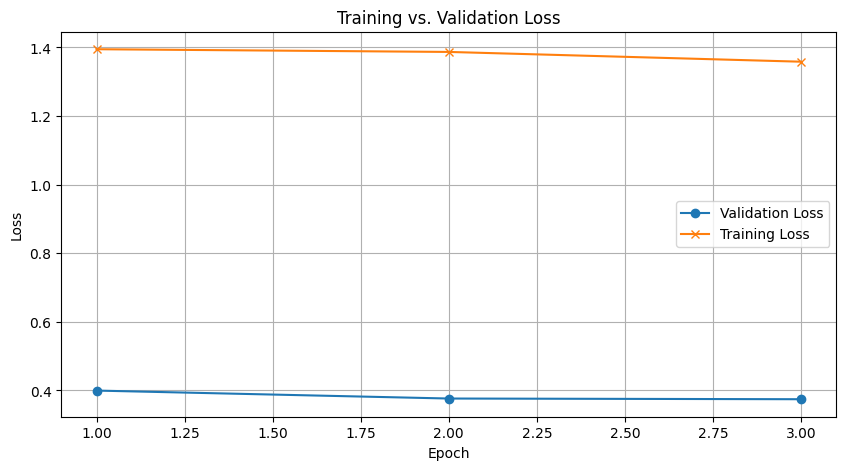

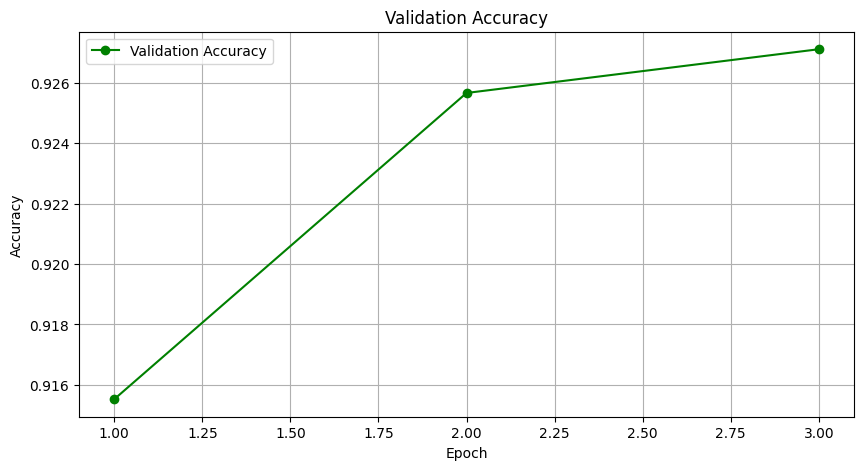

In [15]:
import matplotlib.pyplot as plt

# Extract the trainer state log history
logs = trainer.state.log_history

# Separate training loss, eval loss, and accuracy
train_loss = [log["loss"] for log in logs if "loss" in log and "epoch" in log]
eval_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]
eval_accuracy = [log["eval_accuracy"] for log in logs if "eval_accuracy" in log]
epochs = [log["epoch"] for log in logs if "eval_accuracy" in log]

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, eval_loss, label="Validation Loss", marker='o')
plt.plot(epochs, train_loss[:len(epochs)], label="Training Loss", marker='x')  # Truncate to match epochs
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, eval_accuracy, label="Validation Accuracy", marker='o', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()